# Prediction Intervals vs Confidence Intervals

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

In [2]:
df = pd.read_csv('data/Housing.csv')[['price', 'bedrooms']]
#df['bedrooms'] = df['bedrooms'] -1 #Transforming data to make intercept meaningful
df_dummies = pd.get_dummies(df['bedrooms'], drop_first=True)
df = pd.concat([df, df_dummies], axis=1)

df.head()

,price,bedrooms,2,3,4,5,6
0,13300000,4,False,False,True,False,False
1,12250000,4,False,False,True,False,False
2,12250000,3,False,True,False,False,False
3,12215000,4,False,False,True,False,False
4,11410000,4,False,False,True,False,False


Say we are modelling the price of the house solely on the number of bedrooms variable.

We can easily calculate the mean price of house at each bedroom count.

In [3]:
means = df.groupby('bedrooms')['price'].mean()
means

bedrooms
1    2.712500e+06
2    3.632022e+06
3    4.954598e+06
4    5.729758e+06
5    5.819800e+06
6    4.791500e+06
Name: price, dtype: float64

But this dataset is not population. It is a sample.

So we need to calculate [confidence intervals](https://medium.com/@saikrishna_17904/confidence-intervals-de47ccce3728) of each of these means. To calculate confidence intervals, we need sample standard deviation (S) and sample size (n).

In [4]:
SDs = df.groupby('bedrooms')['price'].std()
SDs 

bedrooms
1    6.187184e+05
2    1.004024e+06
3    1.747527e+06
4    2.307740e+06
5    2.502315e+06
6    1.826457e+06
Name: price, dtype: float64

In [5]:
sample_sizes = df.groupby('bedrooms')['price'].count()
sample_sizes

bedrooms
1      2
2    136
3    300
4     95
5     10
6      2
Name: price, dtype: int64

The sample sizes are different for each category of bedrooms. So, we cannot use 1.96 z-value to calculate the confidence intervals for each of the means above.

In [6]:
from scipy import stats
confidence_level = 0.95
alpha = 1 - confidence_level

t_values = []
for n in sample_sizes:
    dof = n - 1  # degrees of freedom
    t_value = stats.t.ppf(1 - alpha / 2, dof)  # Two-tailed t-value
    t_values.append(t_value)
t_values

[12.706204736432095,
 1.977692277222804,
 1.9679296690653618,
 1.9855234417658298,
 2.2621571627409915,
 12.706204736432095]

In [7]:
import math
ci_lowers = []
ci_uppers = []

for idx, mean in enumerate(means):
    ci_low = mean - t_values[idx]*(SDs.to_list()[idx]/math.sqrt(sample_sizes.to_list()[idx]))
    ci_lowers.append(ci_low)
    ci_up = mean + t_values[idx]*(SDs.to_list()[idx]/math.sqrt(sample_sizes.to_list()[idx]))
    ci_uppers.append(ci_up)

In [8]:
ci_df = pd.DataFrame([means.index, means.to_list(),ci_lowers,ci_uppers]).T
ci_df.columns = ['bedrooms', 'mean', 'ci_low', 'ci_up']
ci_df

,bedrooms,mean,ci_low,ci_up
0,1.0,2.712500e+06,-2.846465e+06,8.271465e+06
1,2.0,3.632022e+06,3.461754e+06,3.802290e+06
2,3.0,4.954598e+06,4.756047e+06,5.153149e+06
3,4.0,5.729758e+06,5.259647e+06,6.199869e+06
4,5.0,5.819800e+06,4.029752e+06,7.609848e+06
5,6.0,4.791500e+06,-1.161856e+07,2.120156e+07


In [9]:
df

,price,bedrooms,2,3,4,5,6
0,13300000,4,False,False,True,False,False
1,12250000,4,False,False,True,False,False
2,12250000,3,False,True,False,False,False
3,12215000,4,False,False,True,False,False
4,11410000,4,False,False,True,False,False
...,...,...,...,...,...,...,...
540,1820000,2,True,False,False,False,False
541,1767150,3,False,True,False,False,False
542,1750000,2,True,False,False,False,False
543,1750000,3,False,True,False,False,False


In [10]:
# Using statsmodels

Y = df['price']
X = df[[2,3,4,5,6]].astype(int)

results = sm.OLS(Y, sm.add_constant(X)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     19.64
Date:                Tue, 15 Oct 2024   Prob (F-statistic):           5.36e-18
Time:                        15:40:16   Log-Likelihood:                -8597.9
No. Observations:                 545   AIC:                         1.721e+04
Df Residuals:                     539   BIC:                         1.723e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.713e+06   1.22e+06      2.220      0.0

In [11]:
means

bedrooms
1    2.712500e+06
2    3.632022e+06
3    4.954598e+06
4    5.729758e+06
5    5.819800e+06
6    4.791500e+06
Name: price, dtype: float64

In [35]:
    predictions = results.get_prediction(sm.add_constant(ff)).summary_frame(alpha=0.05)  # alpha = significance level for confidence interval
predictions

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,5.729758e+06,1.773128e+05,5.381449e+06,6.078067e+06,2.317043e+06,9.142473e+06
1,4.954598e+06,9.977946e+04,4.758594e+06,5.150602e+06,1.554051e+06,8.355145e+06
2,5.819800e+06,5.465146e+05,4.746240e+06,6.893360e+06,2.259205e+06,9.380395e+06
3,3.632022e+06,1.481946e+05,3.340912e+06,3.923132e+06,2.246700e+05,7.039374e+06
4,4.791500e+06,1.222044e+06,2.390948e+06,7.192052e+06,6.336214e+05,8.949379e+06
5,2.712500e+06,1.222044e+06,3.119477e+05,5.113052e+06,-1.445379e+06,6.870379e+06


In [36]:
ci_df

,bedrooms,mean,ci_low,ci_up
0,1.0,2.712500e+06,-2.846465e+06,8.271465e+06
1,2.0,3.632022e+06,3.461754e+06,3.802290e+06
2,3.0,4.954598e+06,4.756047e+06,5.153149e+06
3,4.0,5.729758e+06,5.259647e+06,6.199869e+06
4,5.0,5.819800e+06,4.029752e+06,7.609848e+06
5,6.0,4.791500e+06,-1.161856e+07,2.120156e+07


In [23]:
pd.DataFrame([0,1,0,0,0]).T

,0,1,2,3,4
0,0,1,0,0,0


In [27]:
ff = X.drop_duplicates().reset_index(drop=True).copy()

In [37]:
sample_sizes

bedrooms
1      2
2    136
3    300
4     95
5     10
6      2
Name: price, dtype: int64

In [3]:
df

,price,bedrooms,2,3,4,5,6
0,13300000,4,False,False,True,False,False
1,12250000,4,False,False,True,False,False
2,12250000,3,False,True,False,False,False
3,12215000,4,False,False,True,False,False
4,11410000,4,False,False,True,False,False
...,...,...,...,...,...,...,...
540,1820000,2,True,False,False,False,False
541,1767150,3,False,True,False,False,False
542,1750000,2,True,False,False,False,False
543,1750000,3,False,True,False,False,False


In [20]:
df[df['bedrooms']==5]

,price,bedrooms
112,6083000,5
395,3500000,5
112,6083000,5
395,3500000,5
112,6083000,5
...,...,...
395,3500000,5
112,6083000,5
395,3500000,5
112,6083000,5


In [27]:
df = pd.read_csv('data/Housing.csv')[['price', 'bedrooms']]
df['bedrooms'] = df['bedrooms'] -1 #Transforming data to make intercept meaningful

#for _ in range(10):
 #   df = pd.concat([df, df[df['bedrooms']==5]])
Y = df['price']
X = df['bedrooms']

results = sm.OLS(Y, sm.add_constant(X)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     84.25
Date:                Tue, 15 Oct 2024   Prob (F-statistic):           9.08e-19
Time:                        15:47:32   Log-Likelihood:                -8604.2
No. Observations:                 545   AIC:                         1.721e+04
Df Residuals:                     543   BIC:                         1.722e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.942e+06   2.12e+05     13.850      0.0

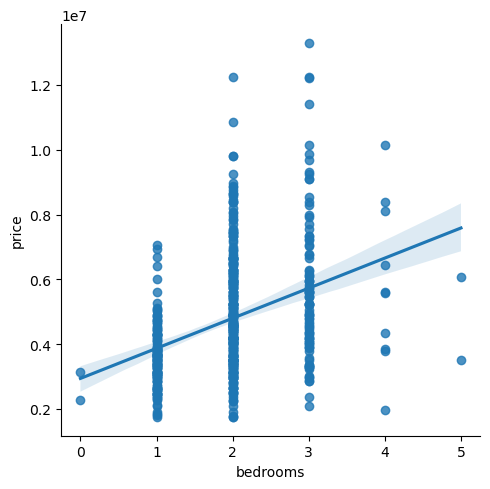

In [28]:
import seaborn as sns

sns.lmplot(x='bedrooms',y='price',data=df)

In [10]:
df = pd.read_csv('data/Housing.csv')[['price', 'bedrooms']]

# OneHot Encode bedrooms variable.
df_dummies = pd.get_dummies(df['bedrooms'], drop_first=True)
df = pd.concat([df, df_dummies], axis=1)

Y = df['price']
X = df[[2,3,4,5,6]].astype(int)

results = sm.OLS(Y, sm.add_constant(X)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     19.64
Date:                Mon, 14 Oct 2024   Prob (F-statistic):           5.36e-18
Time:                        13:57:30   Log-Likelihood:                -8597.9
No. Observations:                 545   AIC:                         1.721e+04
Df Residuals:                     539   BIC:                         1.723e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.713e+06   1.22e+06      2.220      0.0

In [34]:
(9.195221e+05 +1.322576e+06)/2

1121049.05

In [39]:
(9.195221e+05 + 9.004211e+04)/2

504782.105

In [36]:
4792000.01/6

798666.6683333333

In [59]:
(means.diff(1)* sample_sizes).sum()/545

1090480.405025516

545

In [33]:
2079000.0100000002

2079000.0100000002

In [43]:
2.713e+06 + 3.107e+06

5820000.0

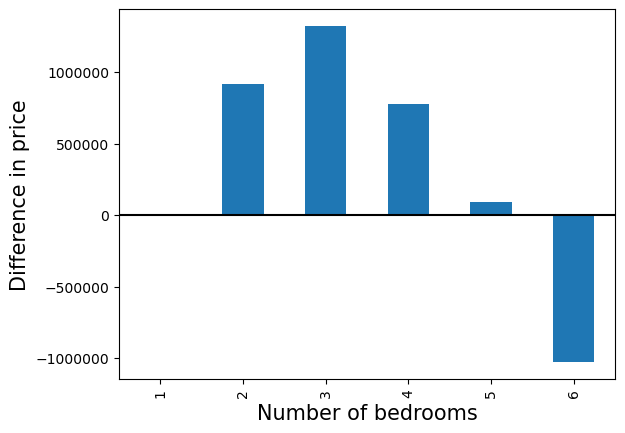

In [95]:
import matplotlib.pyplot as plt

means.diff(1).plot(kind='bar')
plt.axhline(0, c='black')
plt.xlabel('Number of bedrooms', fontsize=15)
plt.ylabel('Difference in price', fontsize=15)

plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.show()

In [78]:
Y = np.array(means.to_list())
X = np.array([1,2,3,4,5,6])

results = sm.OLS(Y, sm.add_constant(X)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     6.126
Date:                Mon, 14 Oct 2024   Prob (F-statistic):             0.0686
Time:                        16:18:56   Log-Likelihood:                -89.260
No. Observations:                   6   AIC:                             182.5
Df Residuals:                       4   BIC:                             182.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.833e+06   7.97e+05      3.554      0.0

C:\Users\dskcy\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [79]:
Y

array([2712500.        , 3632022.05882353, 4954598.13333333,
       5729757.89473684, 5819800.        , 4791500.        ])

In [82]:
means.diff(1).mean()/100000

4.158